## DEX US EU

In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random_walk_model import (
    discretise_Wt,
    simulate_multiple_discrete_paths,
    forecast_from_multiple_paths,
    plot_multiple_paths_vs_history
)
from arima_model import (
    simulate_paths_and_plot,
    evaluate_simulations
)
from rmse import (
    evaluate_rmse_mae_per_path
)


# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-05,1.1918,1.1918,0.175465,-0.008106,-0.008049
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001566
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009709
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000705
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001665


### Random Walk

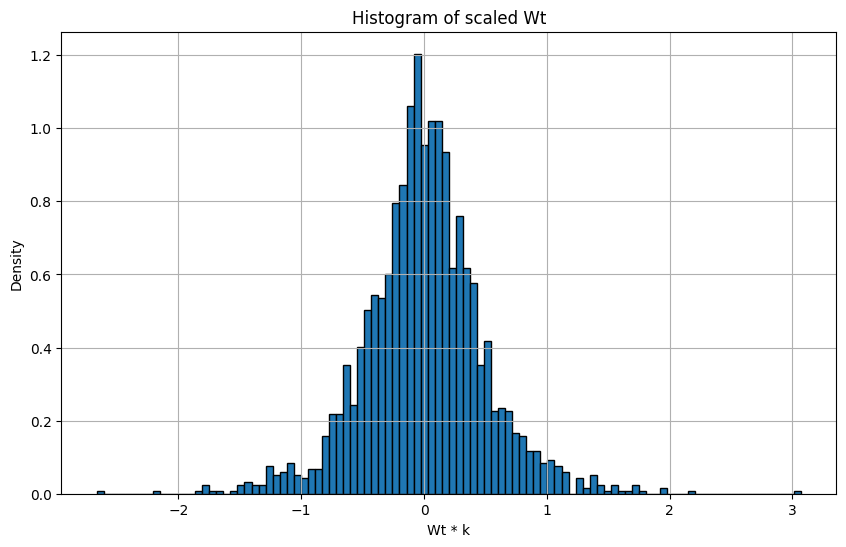

count    2085.000000
mean        0.000001
std         0.004929
min        -0.026667
25%        -0.002622
50%        -0.000034
75%         0.002716
max         0.030700
Name: Wt, dtype: float64


In [73]:
k = 100
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1247, P(0) = 0.7535, P(+1) = 0.1218


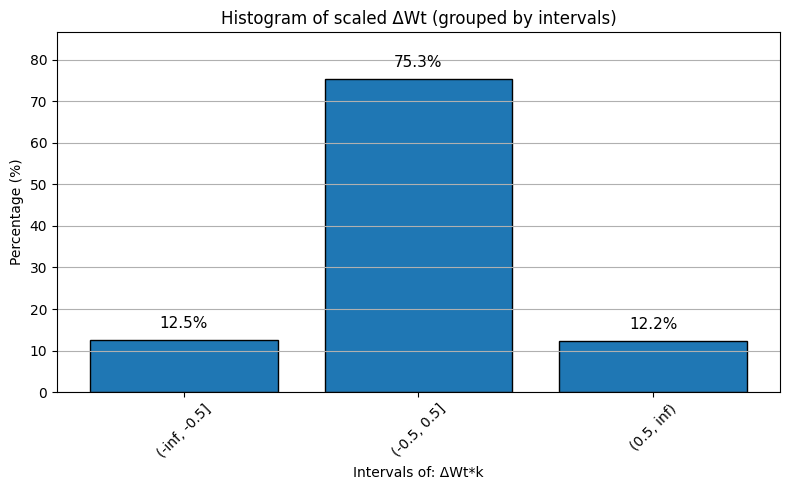

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-05,1.1918,1.19180,0.175465,-0.008106,-0.008049,-0.804883,-1,"(-inf, -0.5]"
2015-01-06,1.1936,1.19360,0.176974,0.001509,0.001566,0.156636,0,"(-0.5, 0.5]"
2015-01-07,1.1820,1.18200,0.167208,-0.009766,-0.009709,-0.970885,-1,"(-inf, -0.5]"
2015-01-08,1.1811,1.18110,0.166446,-0.000762,-0.000705,-0.070453,0,"(-0.5, 0.5]"
2015-01-09,1.1830,1.18300,0.168054,0.001607,0.001665,0.166456,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,NaN,1.06375,0.061800,0.001552,0.001610,0.160950,0,"(-0.5, 0.5]"
2022-12-27,1.0654,1.06540,0.063350,0.001550,0.001607,0.160710,0,"(-0.5, 0.5]"
2022-12-28,1.0622,1.06220,0.060342,-0.003008,-0.002951,-0.295090,0,"(-0.5, 0.5]"


In [74]:
# ----------------------------------------
# with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
k=100
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu


In [75]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.13, 0: 0.74, 1: 0.13}

# trend estimation (preproccessing)
estimated_mu = -0.000004  # this must be your actual drift!
estimated_mu = -0.000057

# df for testing
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

#### Forecasting

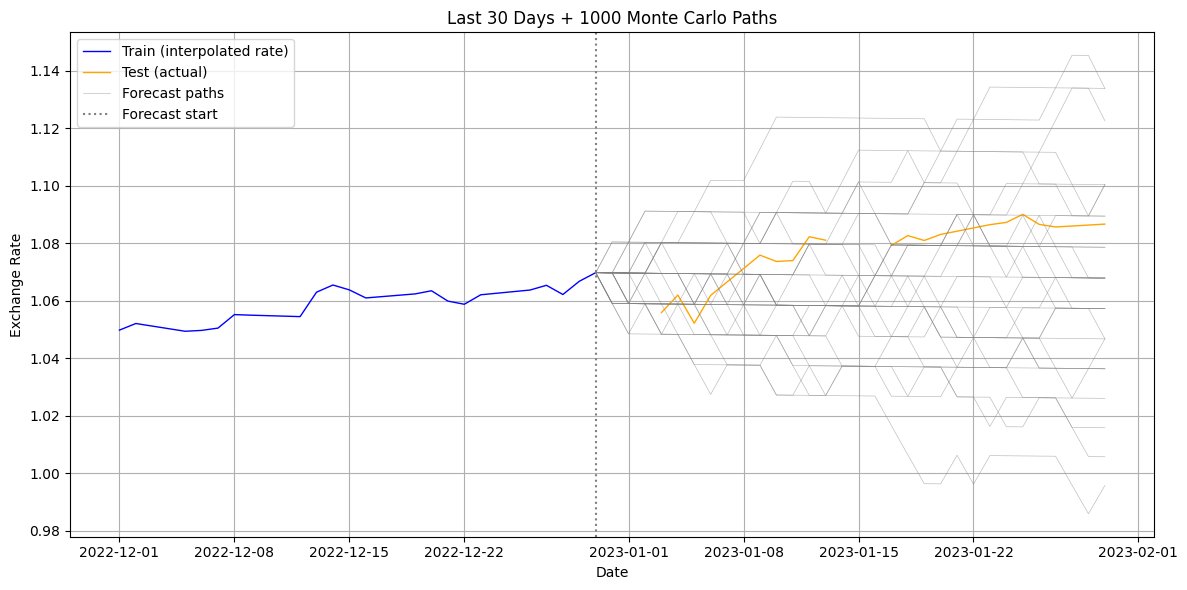

Expected RMSE (Monte Carlo): 0.023752
Expected MAE  (Monte Carlo): 0.020811


In [76]:
# RW for 1 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=31,      # simulate 1 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 1 month
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")


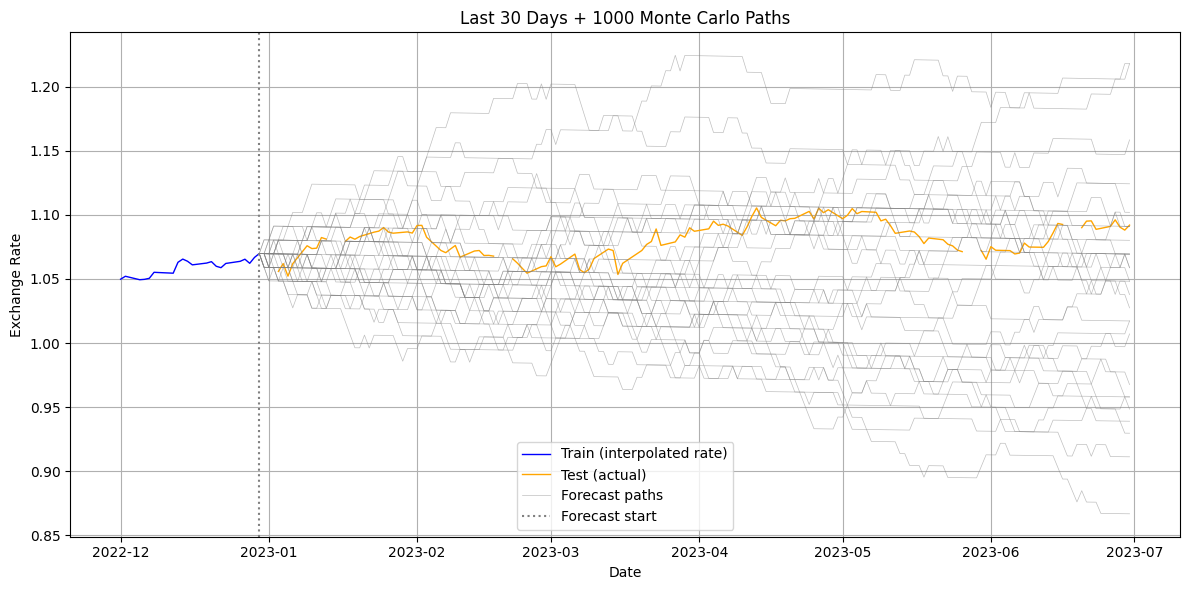

Expected RMSE (Monte Carlo): 0.051179
Expected MAE  (Monte Carlo): 0.043700


In [77]:
# RW for 6 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon= 182,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 6 month
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

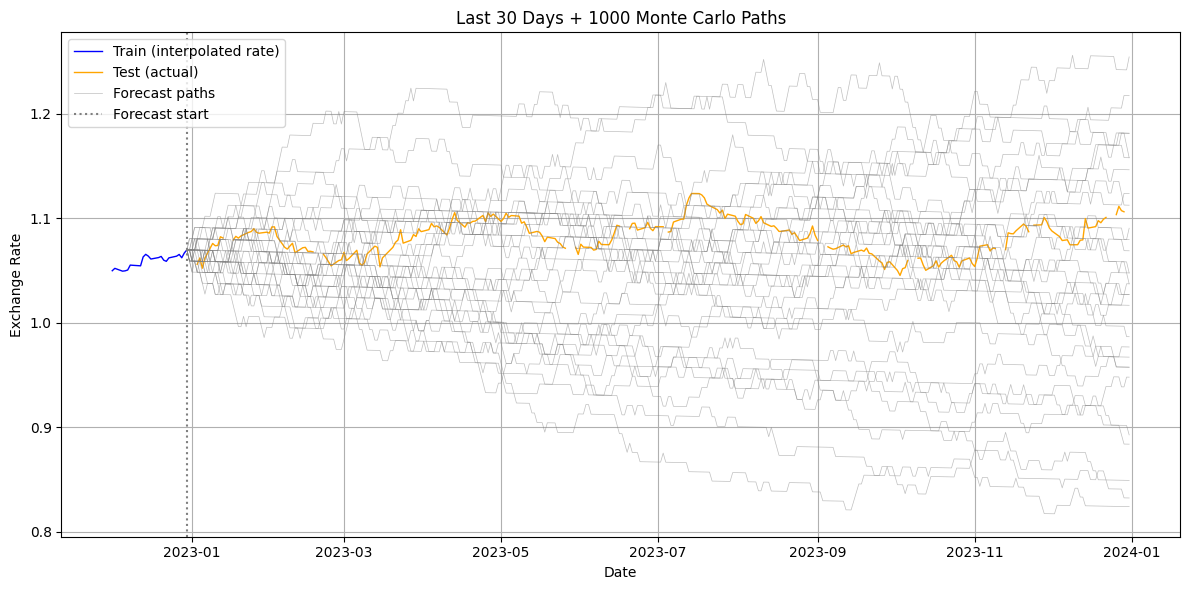

Expected RMSE (Monte Carlo): 0.070647
Expected MAE  (Monte Carlo): 0.060366


In [78]:
# RW for 12 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 12 month
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

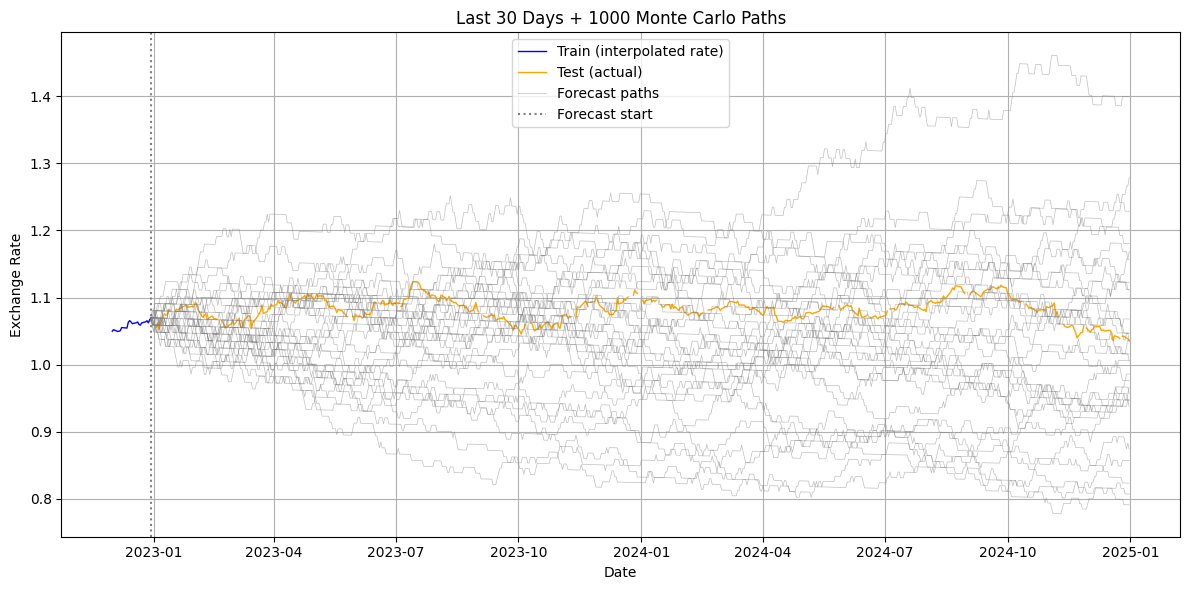

Expected RMSE (Monte Carlo): 0.097083
Expected MAE  (Monte Carlo): 0.083316


In [79]:
# RW for 2 years

# Step 2: Simulate discrete random walk 
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 2 years
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

### ARIMA model

In [80]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# train_df is already loaded with index as date
series = train_df['log_rate'] # or diff? or Wt?


In [81]:
# DETERMINE d (differencing order) using ADF and KPSS tests
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# with pmdarima helper:
d_adf = ndiffs(train_df['log_rate'], test='adf')
# d_kpss = ndiffs(train_df['log_rate'], test='kpss')
print("Recommended d (ADF):", d_adf)
# print("Recommended d (KPSS):", d_kpss)

# Direct ADF test  Augmented Dickey-Fuller already done in preprocessing
adf_res = adfuller(train_df['log_rate'])
print("ADF p-value:", adf_res[1])

Recommended d (ADF): 1
ADF p-value: 0.12271024894831561


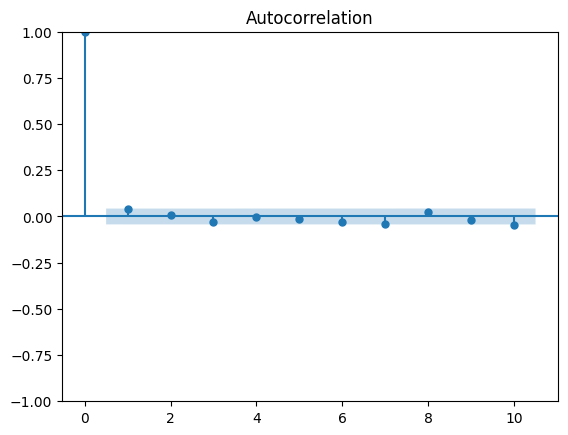

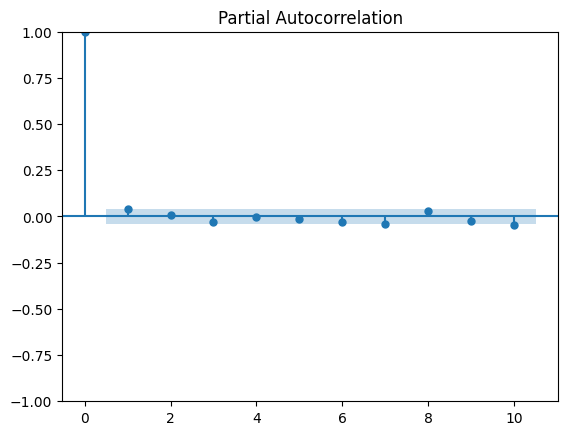

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# diff_series = train_df['log_rate'].diff().dropna()
diff_series = train_df['Wt'].dropna()

# selct q: with ACF autocorrelation function
plot_acf(diff_series, lags=10)
plt.show()

# for select p with PACF partial autocorrelation function
plot_pacf(diff_series, lags=10)
plt.show()

In [83]:
# Using auto arima to selct p and q
import pmdarima as pm

auto_model = pm.auto_arima(train_df['log_rate'],
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=1, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True)

print(auto_model.summary())
p, d, q = auto_model.order
print(f"Best order: p={p}, d={d}, q={q}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16227.269, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16229.198, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16229.144, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16229.038, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16227.233, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16227.212, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16221.266, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16230.987, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16229.026, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16229.003, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16230.934, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16227.024, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.299 seconds
                               SARIMAX Results                  

In [84]:
# Interpretation:

# ar.L1 (coef = 0.0321): a small positive AR(1) effect.
# std err (0.018): standard error of the coefficient.
# z = 1.740 and P>|z| = 0.082: the test statistic and p-value for H0: coefficient = 0. 
# Since p = 0.082 > 0.05, ar.L1 is not statistically significant at 5% (there’s ~8.2% chance the coefficient is zero).


# [0.975 & 0.025]: 95 % confidence interval for each parameter:
# For ar.L1: from –0.004 to 0.068 → interval crosses zero → not significant.
# For sigma2: its narrow interval (2.49e‑05 – 2.72e‑05) is always > 0 → noise variance significantly non-zero.

In [85]:
# Ljung‑Box (L1) Q = 0.00, Prob(Q) = 0.99
# — Tests autocorrelation of residuals. High p‑value (0.99) → cannot reject null → residuals behave like white noise.

# Jarque–Bera (JB) = 413.49, Prob(JB) = 0.00
# — Tests normality. p‑value 0 → residuals are not normally distributed (non-normality indicated).

# Heteroskedasticity (H) = 0.59, Prob(H) = 0.00
# — Tests constant variance. p‑value 0 → residuals have non-constant variance (heteroskedastic).

# Skew = 0.04, Kurtosis = 5.23
# — Slightly heavier tails (kurtosis > 3), mild asymmetry.

In [86]:
# Fit the final ARIMA model
model = ARIMA(train_df['log_rate'], order=(1,1,0))
res = model.fit()

In [87]:
# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

#### Forecasting ARIMA

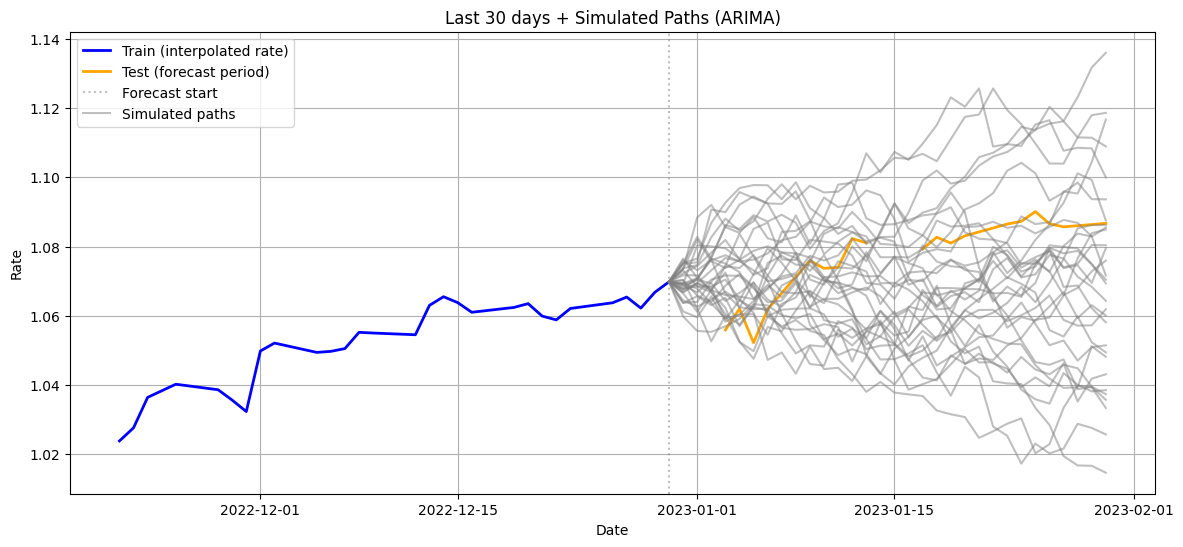

Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Mean RMSE: 0.023335
✅ Mean MAE: 0.020362


In [88]:
# ARIMA Forecasting and Evaluation 31 DAYS

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=31, 
                                    n_sims=1000, 
                                    rate_col='rate_interpolated')
# 2) Evaluate simulations
metrics = evaluate_simulations(all_paths, test_df, rate_col='rate')


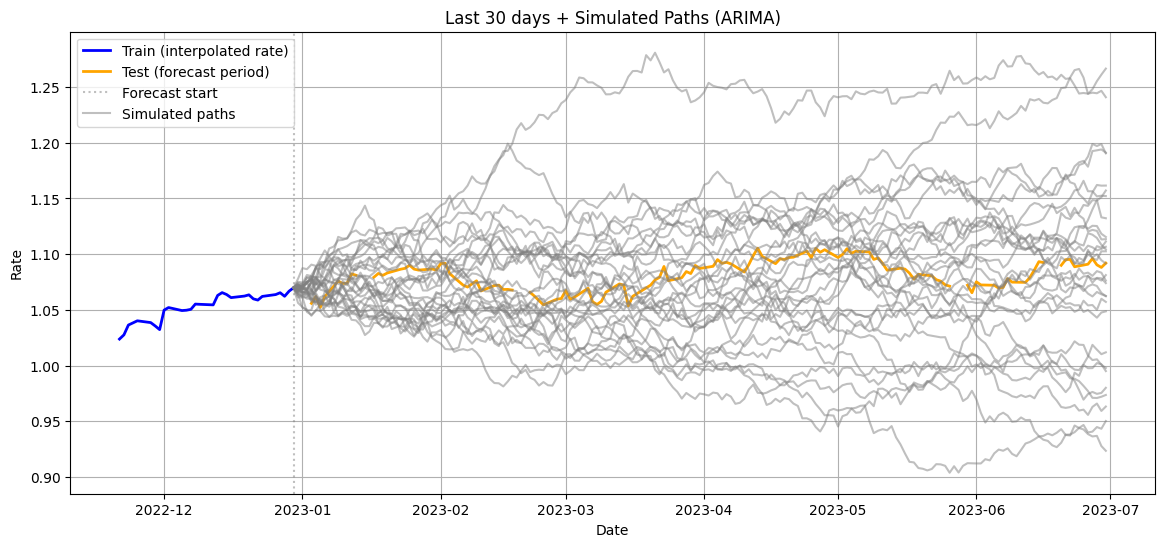

Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Mean RMSE: 0.049325
✅ Mean MAE: 0.042184


In [90]:
# ARIMA Forecasting and Evaluation 6 months

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=182, 
                                    n_sims=1000, 
                                    rate_col='rate_interpolated')
# 2) Evaluate simulations
metrics = evaluate_simulations(all_paths, test_df, rate_col='rate')

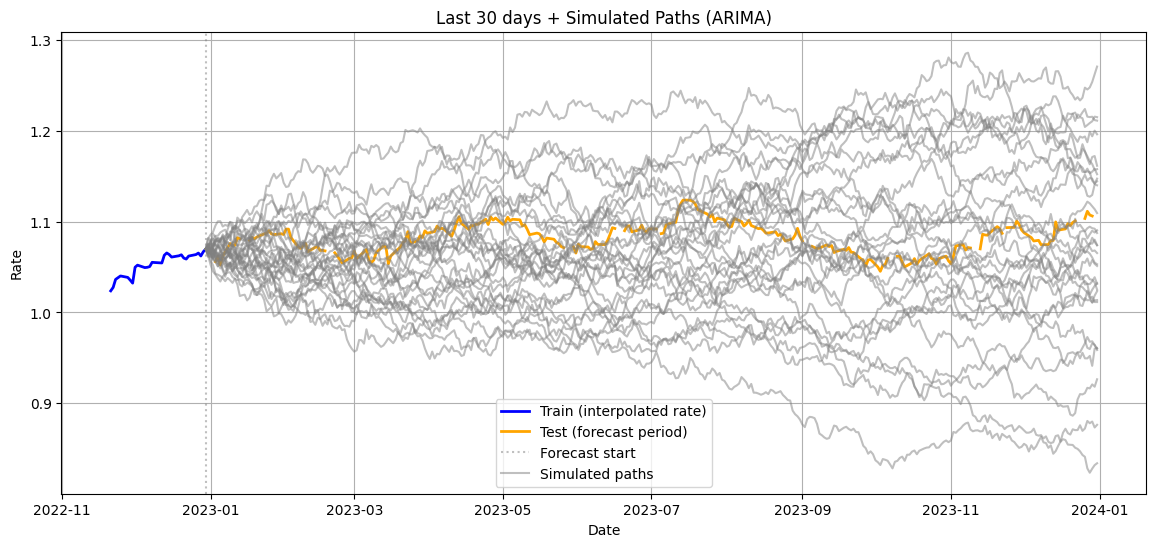

Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Mean RMSE: 0.068399
✅ Mean MAE: 0.057901


In [ ]:
# ARIMA Forecasting and Evaluation 12 months

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=366, 
                                    n_sims=1000, 
                                    rate_col='rate_interpolated')
# 2) Evaluate simulations
metrics = evaluate_simulations(all_paths, test_df, rate_col='rate')

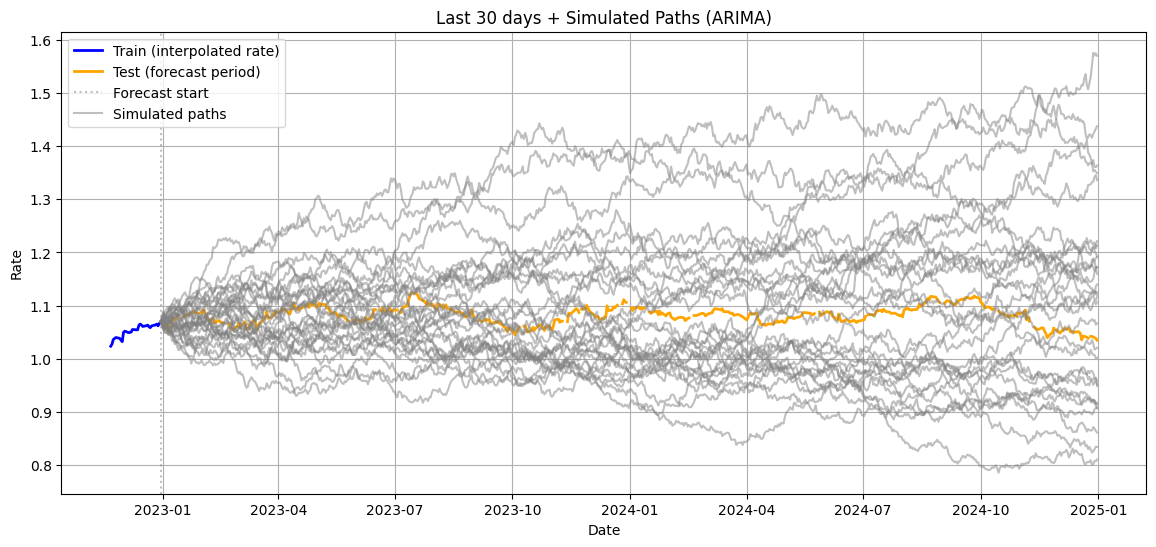

Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Mean RMSE: 0.097253
✅ Mean MAE: 0.083119


In [ ]:
# ARIMA Forecasting and Evaluation 2 years

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=366*2, 
                                    n_sims=1000, 
                                    rate_col='rate_interpolated')
# 2) Evaluate simulations
metrics = evaluate_simulations(all_paths, test_df, rate_col='rate')

In [ ]:
# lower than RW, ARIMA is better than RW for 1 month, 6 , 12, 24 month ahead forecasts

### Structural Model

In [205]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ------------------------
# 1) Load data
# ------------------------
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', parse_dates=True, index_col=0).sort_index()
test_df  = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv',  parse_dates=True, index_col='date').sort_index()

m1_eu  = pd.read_csv('../2. preprocesing/M1_EU_daily.csv',                 parse_dates=True, index_col=0).sort_index()
m1_us  = pd.read_csv('../2. preprocesing/M1_USA_daily.csv',                parse_dates=True, index_col=0).sort_index()
r3m_eu = pd.read_csv('../2. preprocesing/interest_rate_3m_EU_daily.csv',   parse_dates=True, index_col=0).sort_index()
r3m_us = pd.read_csv('../2. preprocesing/interest_rate_3m_USA_daily.csv',  parse_dates=True, index_col=0).sort_index()
ip_eu  = pd.read_csv('../2. preprocesing/INDPRO_EU_daily.csv',             parse_dates=True, index_col=0).sort_index()
ip_us  = pd.read_csv('../2. preprocesing/INDPRO_USA_daily.csv',            parse_dates=True, index_col=0).sort_index()

# Ensure expected column names (robust to unknown original headers)
def set_single_col(df, name):
    if df.shape[1] != 1:
        raise ValueError(f"Expected 1 column in {name}, got {df.shape[1]}")
    df.columns = [name]
    return df

m1_eu  = set_single_col(m1_eu,  'M1_EU')
m1_us  = set_single_col(m1_us,  'M1_US')
r3m_eu = set_single_col(r3m_eu, 'R3M_EU')
r3m_us = set_single_col(r3m_us, 'R3M_US')
ip_eu  = set_single_col(ip_eu,  'IP_EU')
ip_us  = set_single_col(ip_us,  'IP_US')

# ------------------------
# 2) Build a base daily index (train + test + fundamentals)
#    Use the union so we never drop test dates again.
# ------------------------
base_index = train_df.index.union(test_df.index)\
    .union(m1_eu.index).union(m1_us.index)\
    .union(r3m_eu.index).union(r3m_us.index)\
    .union(ip_eu.index).union(ip_us.index)

# enforce daily regularity if you prefer a contiguous D-frequency grid
base_index = pd.date_range(base_index.min(), base_index.max(), freq='D')

# ------------------------
# 3) Reindex and merge (left joins on the base index)
#    Forward-fill only fundamentals; do NOT fabricate FX values.
# ------------------------
fx_cols = ['rate', 'rate_interpolated', 'log_rate']
fx = train_df.reindex(base_index)[fx_cols]  # keep train values; outside train these are NaN

# fundamentals: forward-fill to daily (they are daily already, but to align holidays/missing days)
funds = (
    m1_us.reindex(base_index).ffill()
    .join(m1_eu.reindex(base_index).ffill())
    .join(r3m_us.reindex(base_index).ffill())
    .join(r3m_eu.reindex(base_index).ffill())
    .join(ip_us.reindex(base_index).ffill())
    .join(ip_eu.reindex(base_index).ffill())
)

df_all = fx.join(funds, how='left')

# ------------------------
# 4) Construct structural features
# ------------------------
# Guard against non-positive values in logs
for col in ['M1_US','M1_EU','IP_US','IP_EU']:
    if (df_all[col] <= 0).any():
        raise ValueError(f"{col} has non-positive values; cannot take log.")

df_all['m_diff'] = np.log(df_all['M1_US']) - np.log(df_all['M1_EU'])
df_all['y_diff'] = np.log(df_all['IP_US'])  - np.log(df_all['IP_EU'])
df_all['r_diff'] = df_all['R3M_US'] - df_all['R3M_EU']

feature_cols = ['m_diff','y_diff','r_diff']
y_col = 'log_rate'
rate_col = 'rate_interpolated'  # use your interpolated daily rate for sim/eval


df_all

,rate,rate_interpolated,log_rate,M1_US,M1_EU,R3M_US,R3M_EU,IP_US,IP_EU,m_diff,y_diff,r_diff
2015-01-01,NaN,NaN,NaN,2941.100000,5.969987e+06,0.03,0.062667,102.346000,99.691692,-7.615716,0.026277,-0.032667
2015-01-02,NaN,NaN,NaN,2942.341935,5.972024e+06,0.03,0.062667,102.332045,99.691692,-7.615635,0.026141,-0.032667
2015-01-03,NaN,NaN,NaN,2943.583871,5.974062e+06,0.03,0.062667,102.318090,99.691692,-7.615554,0.026004,-0.032667
2015-01-04,NaN,NaN,NaN,2944.825806,5.976099e+06,0.03,0.062667,102.304135,99.691692,-7.615474,0.025868,-0.032667
2015-01-05,1.1918,1.1918,0.175465,2946.067742,5.978137e+06,0.03,0.062667,102.290181,99.691692,-7.615393,0.025731,-0.032667
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,NaN,NaN,NaN,18511.800000,1.065264e+07,4.27,2.816091,102.583500,108.090992,-6.355155,-0.052296,1.453909
2024-12-28,NaN,NaN,NaN,18511.800000,1.065482e+07,4.27,2.816091,102.583500,108.090992,-6.355360,-0.052296,1.453909
2024-12-29,NaN,NaN,NaN,18511.800000,1.065701e+07,4.27,2.816091,102.583500,108.090992,-6.355564,-0.052296,1.453909
2024-12-30,NaN,NaN,NaN,18511.800000,1.065919e+07,4.27,2.816091,102.583500,108.090992,-6.355769,-0.052296,1.453909


#### Dornbusch-Frankel 

In [ ]:
# Model β (OLS) y ϕ (AR(1) of residuals)
# log_rate = β0 + β1 * m_diff + β2 * y_diff + β3 * r_diff + u

# ------------------------
# 5) Fit OLS ONLY on the train window
# ------------------------
last_train_date = train_df.index.max()
train_mask = (df_all.index <= last_train_date)

df_train = df_all.loc[train_mask, [y_col, *feature_cols]].dropna()
if df_train.empty:
    raise ValueError("No rows to fit after dropna(). Check column names and merges.")

X = sm.add_constant(df_train[feature_cols])
y = df_train[y_col]
model = sm.OLS(y, X).fit()
print(model.summary())

# Residuals aligned to df_all index (NaN outside train)
residuals = pd.Series(np.nan, index=df_all.index, name='resid')
residuals.loc[df_train.index] = model.resid

# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 31             # 1 month
n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()

# If the requested steps overrun available future features, truncate & warn
if len(exog_future) < steps:
    print(f"[WARN] exog_future shorter than steps ({len(exog_future)} < {steps}). Truncating simulation horizon.")
    steps = len(exog_future)

                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     34.39
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           1.08e-21
Time:                        12:57:16   Log-Likelihood:                 3414.9
No. Observations:                2085   AIC:                            -6822.
Df Residuals:                    2081   BIC:                            -6799.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0880      0.012      7.180      0.0

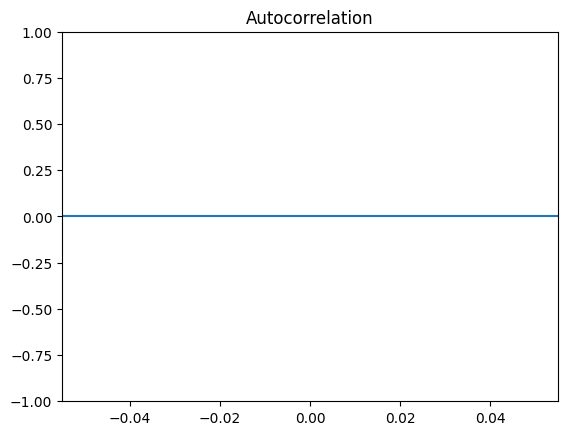

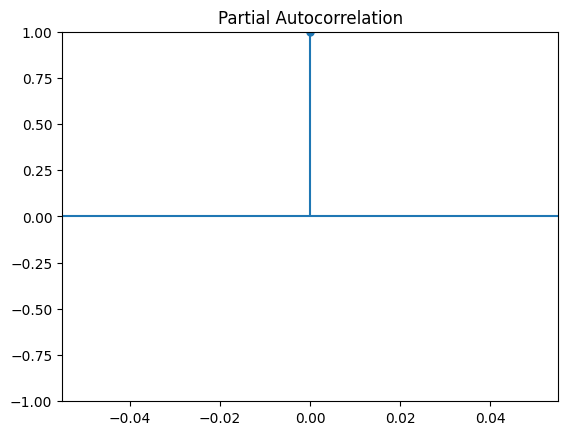

In [189]:
from statsmodels.tsa.ar_model import AutoReg
# u = residuals = 
# u_t = ϕ u_t−1 +ε_t

# Estimar AR(1) en los residuos
ar_model = AutoReg(residuals, lags=1).fit()
phi = ar_model.params[1]  # AR(1) coefficient
sigma = np.std(ar_model.resid)  # std of innovation
print(f"Estimated phi (AR1): {phi:.4f}, sigma: {sigma:.4f}")


Estimated phi (AR1): 0.9943, sigma: 0.0049


##### Forecasting structural model 

In [204]:
def report_nans(df, name):
    if not df.isna().any().any():
        print(f"[OK] {name}: no NaNs.")
        return
    print(f"[WARN] {name} has NaNs:")
    for col in df.columns:
        idx = df.index[df[col].isna()]
        if len(idx) > 0:
            start = idx.min().strftime('%Y-%m-%d')
            end   = idx.max().strftime('%Y-%m-%d')
            print(f"   - {col}: {len(idx)} NaNs between {start} and {end}")

# Initial diagnostics
report_nans(exog_future, "exog_future (raw)")

[OK] exog_future (raw): no NaNs.


In [203]:
# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],   # pass train residuals (the function may only need AR(1) fit)
    df=df_all,                                 # <- includes train + test + fundamentals
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,                   # <- FUTURE REAL FUNDAMENTALS
    use_last_resid=True,
    seed=42,
    test_df=test_df                            # unchanged; used only for evaluation
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
if test_df is not None and steps > 0:
    metrics = evaluate_structural_sims(
        all_paths=all_paths,
        test_df=test_df,
        rate_col='rate',        # use the column present in your test_df
        steps=steps,
        compute_coverage=True,
        verbose=True
    )
    print(metrics)

ValueError: exog_future contains non-numeric/NaN after coercion in columns: ['m_diff', 'y_diff', 'r_diff']

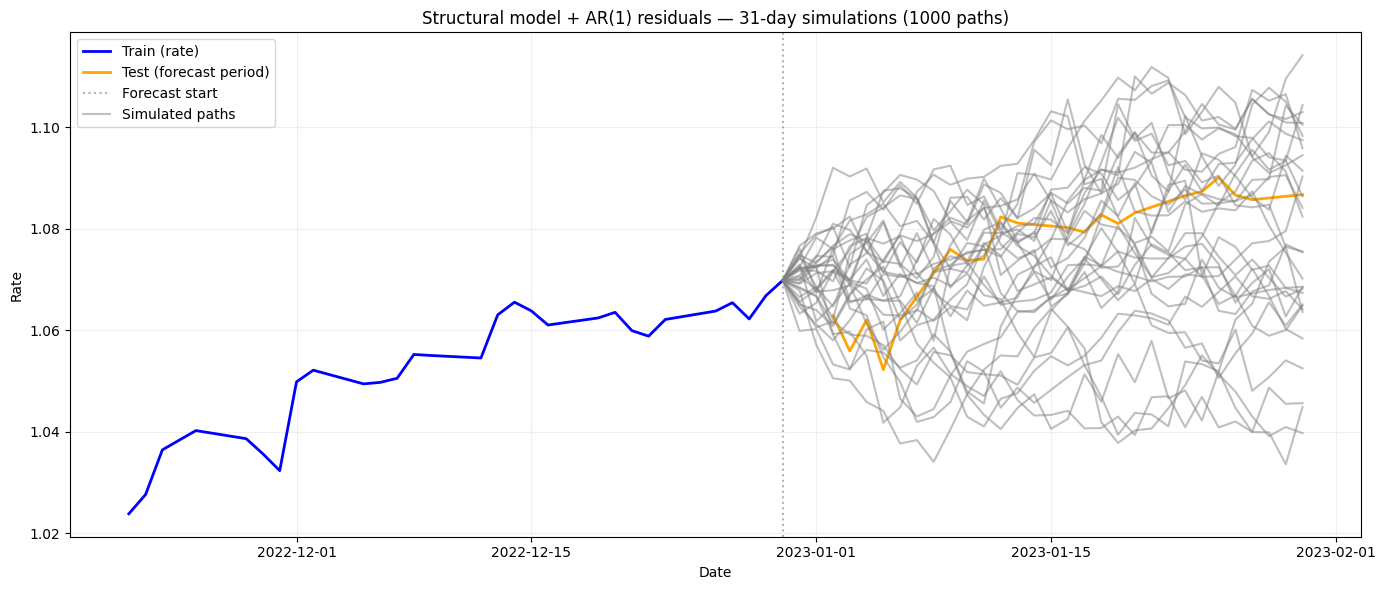

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Mean RMSE (per-path): 0.020145
✅ Mean MAE  (per-path): 0.017623
🤝 Ensemble mean RMSE:   0.008792
🤝 Ensemble mean MAE:    0.007707
📐 Ensemble median RMSE: 0.009154
📐 Ensemble median MAE:  0.008126
🎯 Coverage 50%: 0.789 | 80%: 0.895 | 95%: 1.000


In [ ]:
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims



steps = 31       # 1 month
n_sims = 1000     # nº of paths

# (Opcional) Si no tienes fundamentales futuros, omite 'exog_future'
exog_future = None

# test data frame for evaluation
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', 
                      index_col='date', parse_dates=True)

# ---------- SIMULAtTION AND PLOT ----------
all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals,
    df=df,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col='rate_interpolated',
    log_rate_col='log_rate',
    feature_cols=('m_diff','y_diff','r_diff'),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df
)

print("AR(1) params:", ar1_params)  # {'phi': ..., 'sigma': ...}

# ---------- EVALUATION ----------
if test_df is not None:
    metrics = evaluate_structural_sims(
        all_paths=all_paths,
        test_df=test_df,
        rate_col='rate',
        steps=steps,
        compute_coverage=True,
        verbose=True
    )

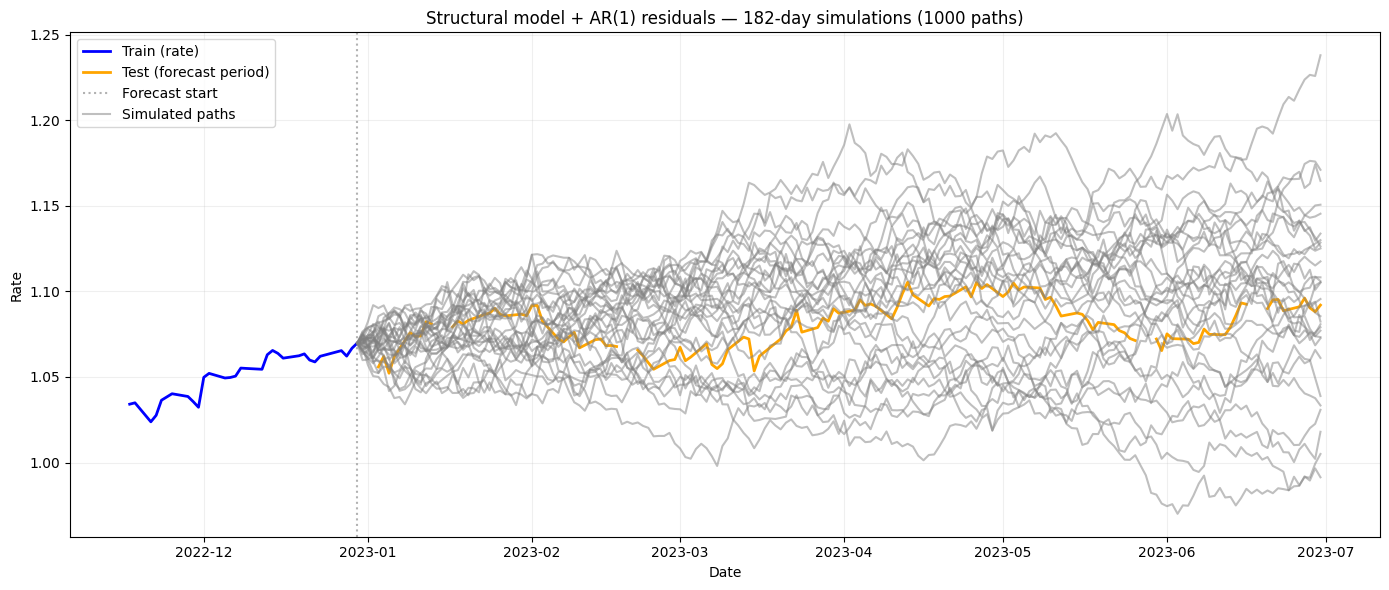

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Mean RMSE (per-path): 0.039526
✅ Mean MAE  (per-path): 0.033369
🤝 Ensemble mean RMSE:   0.016238
🤝 Ensemble mean MAE:    0.013286
📐 Ensemble median RMSE: 0.015900
📐 Ensemble median MAE:  0.013045
🎯 Coverage 50%: 0.880 | 80%: 0.984 | 95%: 1.000


In [182]:
steps = 182      # 6 month
n_sims = 1000     # nº of paths

# (Opcional) Si no tienes fundamentales futuros, omite 'exog_future'
exog_future = None

# test data frame for evaluation
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', 
                      index_col='date', parse_dates=True)

# ---------- SIMULAtTION AND PLOT ----------
all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals,
    df=df,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col='rate',
    log_rate_col='log_rate',
    feature_cols=('m_diff','y_diff','r_diff'),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df
)

print("AR(1) params:", ar1_params)  # {'phi': ..., 'sigma': ...}

# ---------- EVALUATION ----------
if test_df is not None:
    metrics = evaluate_structural_sims(
        all_paths=all_paths,
        test_df=test_df,
        rate_col='rate',
        steps=steps,
        compute_coverage=True,
        verbose=True
    )

In [ ]:
steps = 182      # 6 month
n_sims = 1000     # nº of paths

# (Opcional) Si no tienes fundamentales futuros, omite 'exog_future'
exog_future = None

# test data frame for evaluation
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', 
                      index_col='date', parse_dates=True)

# ---------- SIMULAtTION AND PLOT ----------
all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals,
    df=df,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col='rate',
    log_rate_col='log_rate',
    feature_cols=('m_diff','y_diff','r_diff'),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df
)

print("AR(1) params:", ar1_params)  # {'phi': ..., 'sigma': ...}

# ---------- EVALUATION ----------
if test_df is not None:
    metrics = evaluate_structural_sims(
        all_paths=all_paths,
        test_df=test_df,
        rate_col='rate',
        steps=steps,
        compute_coverage=True,
        verbose=True
    )

## DEX US SF

In [137]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexussf.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-05,0.085357,0.085357,-2.460913,-0.001409,-0.001226
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001465
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000415
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013468
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006087


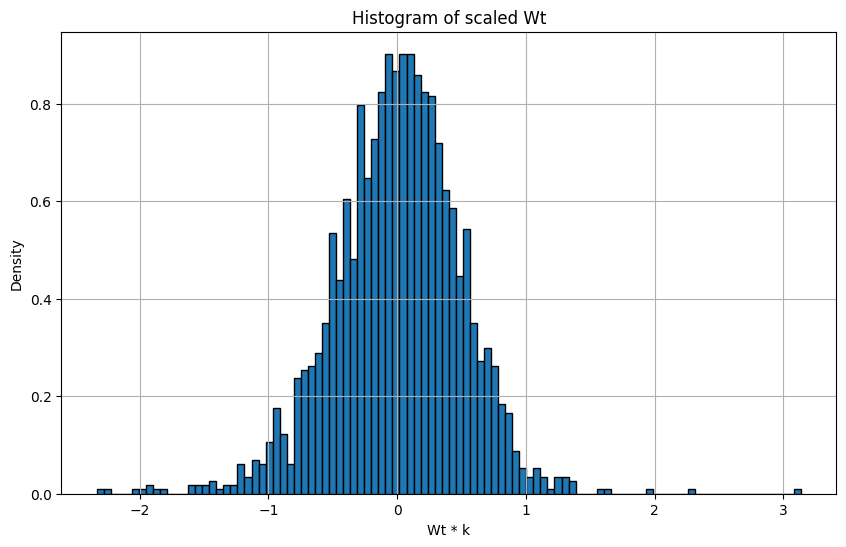

count    2085.000000
mean        0.000004
std         0.009860
min        -0.046718
25%        -0.005882
50%         0.000361
75%         0.006290
max         0.062758
Name: Wt, dtype: float64


In [138]:
k = 50
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1405, P(0) = 0.7185, P(+1) = 0.1410


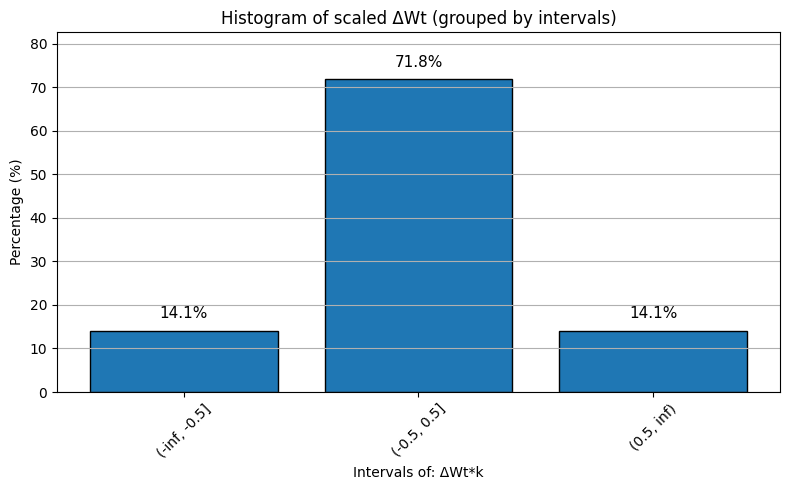

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-05,0.085357,0.085357,-2.460913,-0.001409,-0.001226,-0.061291,0,"(-0.5, 0.5]"
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001465,0.073237,0,"(-0.5, 0.5]"
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000415,-0.020726,0,"(-0.5, 0.5]"
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013468,0.673404,1,"(0.5, inf)"
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006087,0.304344,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,NaN,0.058356,-2.841191,-0.009596,-0.009413,-0.470635,0,"(-0.5, 0.5]"
2022-12-27,0.057793,0.057793,-2.850880,-0.009689,-0.009506,-0.475284,0,"(-0.5, 0.5]"
2022-12-28,0.058428,0.058428,-2.839955,0.010925,0.011108,0.555410,1,"(0.5, inf)"


In [139]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [140]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.15, 0: 0.7, 1: 0.15}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

NameError: name 'simulate_one_discrete_path' is not defined

In [ ]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)


In [ ]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-2.832482,-2.853042,-2.813042,0.058870,0.057669,0.060022
2023-01-01,-2.833065,-2.853165,-2.793165,0.058839,0.057662,0.061227
2023-01-02,-2.833428,-2.873288,-2.793288,0.058822,0.056513,0.061220
2023-01-03,-2.833631,-2.873411,-2.793411,0.058813,0.056506,0.061212
2023-01-04,-2.834034,-2.873534,-2.793534,0.058793,0.056499,0.061205
...,...,...,...,...,...,...
2024-12-25,-2.924717,-3.502217,-2.362217,0.056073,0.030131,0.094211
2024-12-26,-2.924900,-3.502340,-2.362340,0.056071,0.030127,0.094200
2024-12-27,-2.925123,-3.502463,-2.362463,0.056054,0.030123,0.094188
2024-12-28,-2.925326,-3.502586,-2.362586,0.056040,0.030119,0.094176


In [ ]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_dexussf.csv')

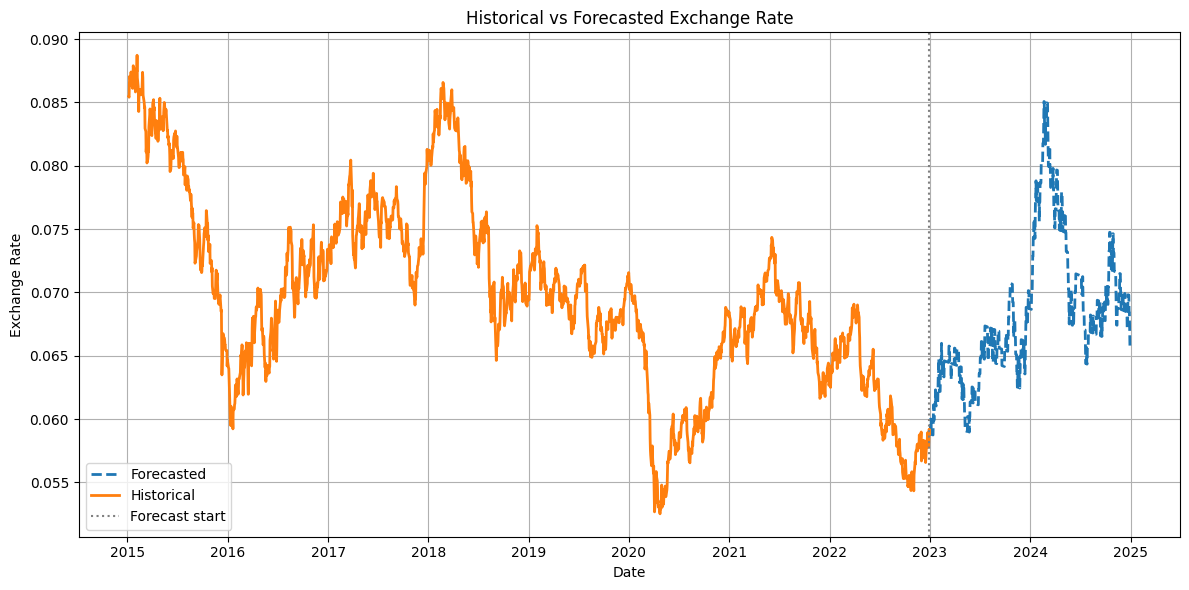

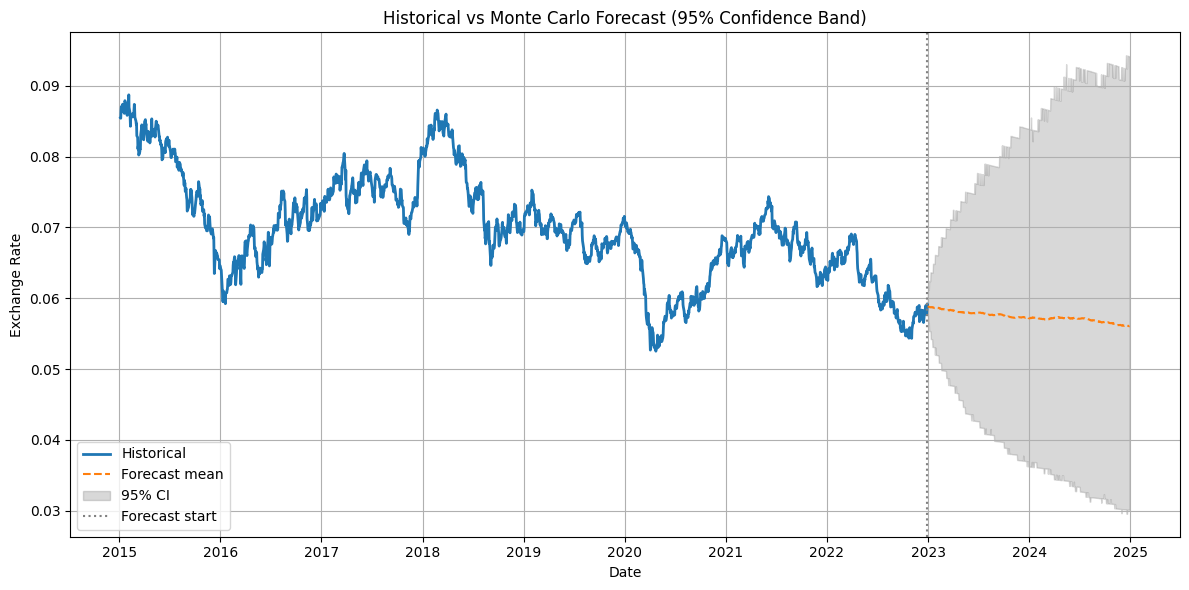

In [ ]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [ ]:
combined_df

,rate,source
date,,
2015-01-06,0.085466,Historical
2015-01-07,0.085415,Historical
2015-01-08,0.086558,Historical
2015-01-09,0.087070,Historical
2015-01-12,0.086760,Historical
...,...,...
2024-12-25,0.056073,Forecasted
2024-12-26,0.056071,Forecasted
2024-12-27,0.056054,Forecasted


## DEX US PEN

In [ ]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_usdpen.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447


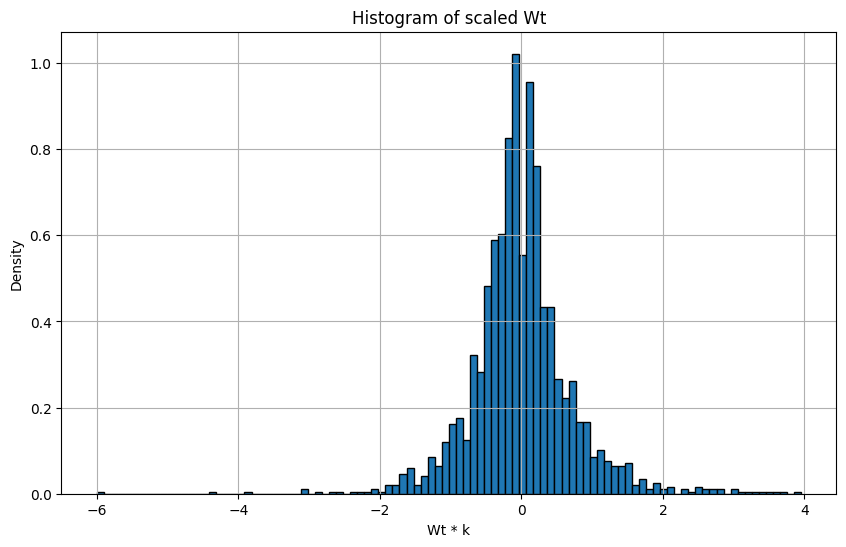

count    1996.000000
mean       -0.000016
std         0.003623
min        -0.030015
25%        -0.001727
50%        -0.000188
75%         0.001528
max         0.019757
Name: Wt, dtype: float64


In [ ]:
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1759, P(0) = 0.6603, P(+1) = 0.1638


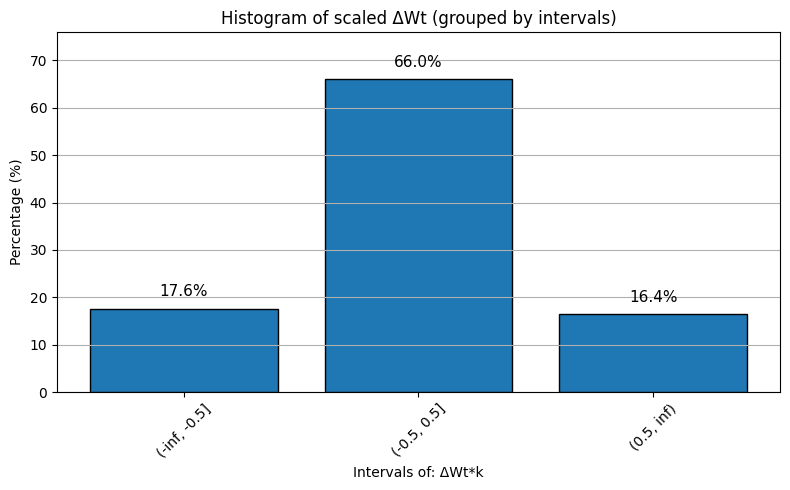

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232,-0.246452,0,"(-0.5, 0.5]"
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562,-0.112314,0,"(-0.5, 0.5]"
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112,0.222392,0,"(-0.5, 0.5]"
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896,-0.179282,0,"(-0.5, 0.5]"
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447,0.289382,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,0.261575,0.261575,-1.341035,0.001046,0.001154,0.230705,0,"(-0.5, 0.5]"
2022-12-27,0.261643,0.261643,-1.340774,0.000262,0.000369,0.073877,0,"(-0.5, 0.5]"
2022-12-28,0.261986,0.261986,-1.339465,0.001309,0.001417,0.283369,0,"(-0.5, 0.5]"


In [ ]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [ ]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.17, 0: 0.66, 1: 0.17}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [ ]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)

In [ ]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-1.340223,-1.345373,-1.335373,0.261788,0.260442,0.263060
2023-01-01,-1.340446,-1.350496,-1.330496,0.261731,0.259112,0.264346
2023-01-02,-1.340609,-1.350619,-1.330619,0.261690,0.259080,0.264313
2023-01-03,-1.340727,-1.350742,-1.330742,0.261660,0.259048,0.264281
2023-01-04,-1.340975,-1.355865,-1.330865,0.261596,0.257724,0.264248
...,...,...,...,...,...,...
2024-12-25,-1.430073,-1.584673,-1.284548,0.240037,0.205015,0.276776
2024-12-26,-1.430256,-1.584671,-1.284671,0.239995,0.205015,0.276741
2024-12-27,-1.430364,-1.589794,-1.284794,0.239969,0.203968,0.276707
2024-12-28,-1.430507,-1.589917,-1.284917,0.239935,0.203942,0.276673


In [ ]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_usdpen.csv')

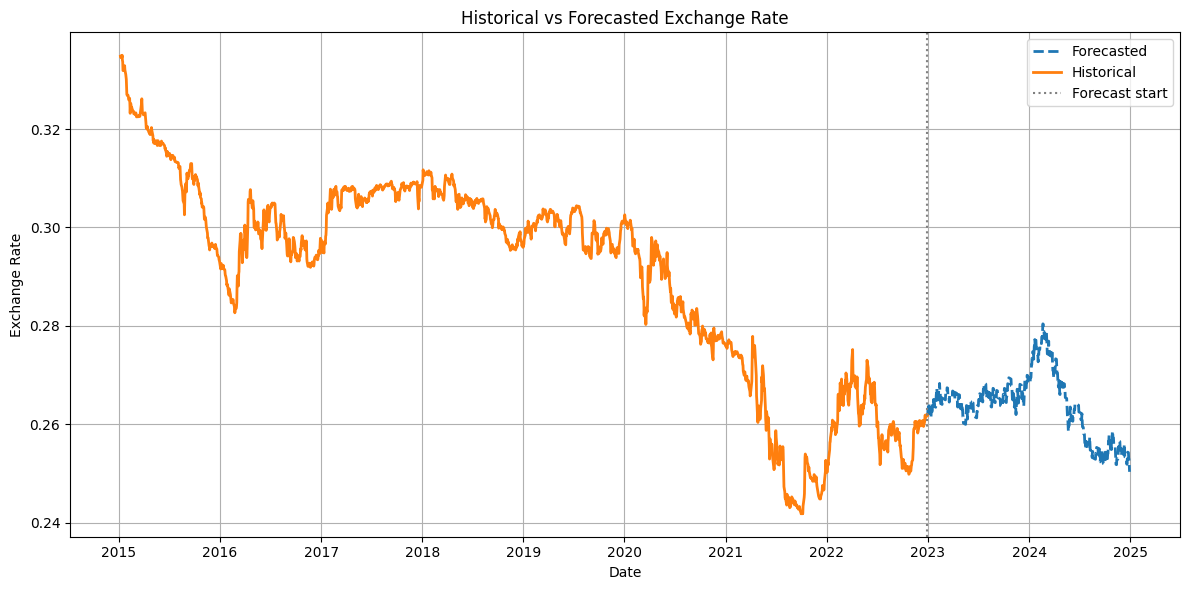

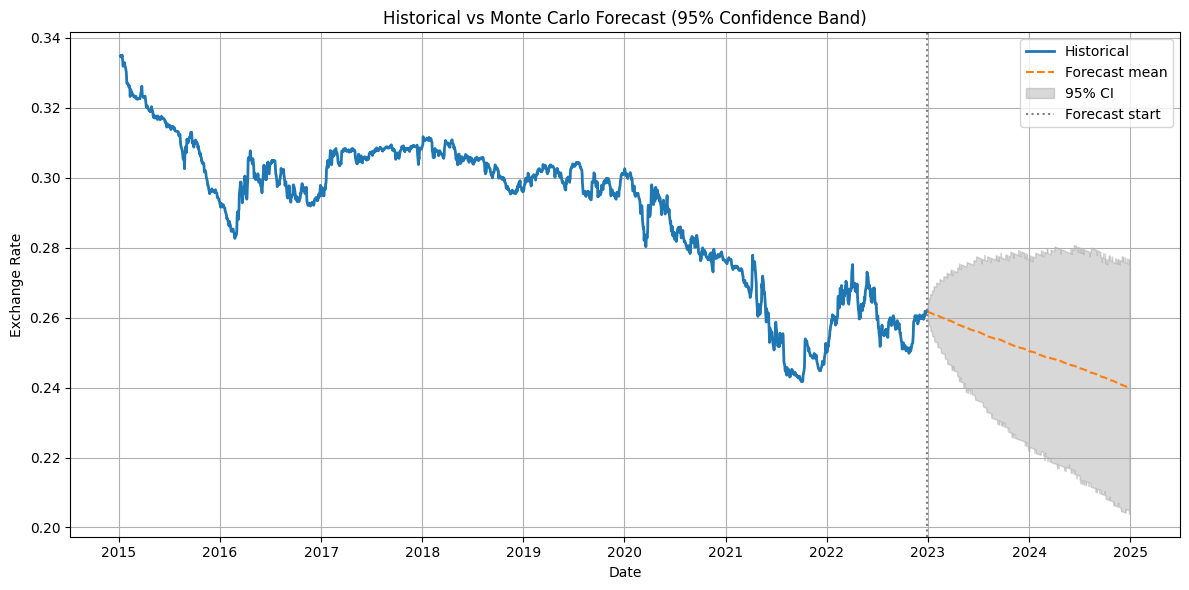

In [ ]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [ ]:
combined_df

,rate,source
date,,
2015-01-07,0.334784,Historical
2015-01-08,0.334560,Historical
2015-01-09,0.334896,Historical
2015-01-12,0.334560,Historical
2015-01-13,0.335008,Historical
...,...,...
2024-12-25,0.240037,Forecasted
2024-12-26,0.239995,Forecasted
2024-12-27,0.239969,Forecasted
